# matchtesting算出matrix

In [27]:
import cv2, numpy as np
import json,math,os
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import os


## 输入

In [28]:
#images_folder="../data/2403261/captured/position_00a/"
images_folder="./data/04231647/captured/position_00/"
phco_path="./data/phco.txt"
aruco_img_path='C:/Users/robert/source/repos/3BPM/test3\WindowsFormsApp1/bin/Debug/net6.0-windows10.0.17763.0/pic2.png'
match_np_path="./result/match.npy"
projector_id=0
pro_size = (640, 480) # Projector image plane size
cam_size = (1280, 720) # Camera image plane size
#是否全部可视化
allvisualization=False


<>:4: SyntaxWarning: invalid escape sequence '\W'
<>:4: SyntaxWarning: invalid escape sequence '\W'
C:\Users\robert\AppData\Local\Temp\ipykernel_28432\802727333.py:4: SyntaxWarning: invalid escape sequence '\W'
  aruco_img_path='C:/Users/robert/source/repos/3BPM/test3\WindowsFormsApp1/bin/Debug/net6.0-windows10.0.17763.0/pic2.png'


In [29]:

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):

        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        #if len(images) == 0:
           # base_img  = img

            #img = cv2.gammaCorrect(img, gamma=1.0)
        # 矫正亮度,让图像与第一张模板匹配
        #else:
            #img = cv2.matchTemplate(img, base_img, cv2.TM_SQDIFF_NORMED)
            #img = cv2.gammaCorrect(img, gamma=1.0)
        #img= cv2.equalizeHist(img)
        if img is not None:
            images.append(img)
    return images


captured_gray_images = load_images_from_folder(images_folder)# Load captured Gray code image for decoding


## Gray解码

#### log2*2 

In [30]:
def computeNumberOfPatternImages(width, height):
    assert width > 0 and height > 0
    n_cols = int(np.ceil(np.log2(width))) * 2 #ceil向上取整 宽度 log2
    n_rows = int(np.ceil(np.log2(height))) * 2
    return n_cols, n_rows

### 1. Gray过滤出匹配点并记录


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


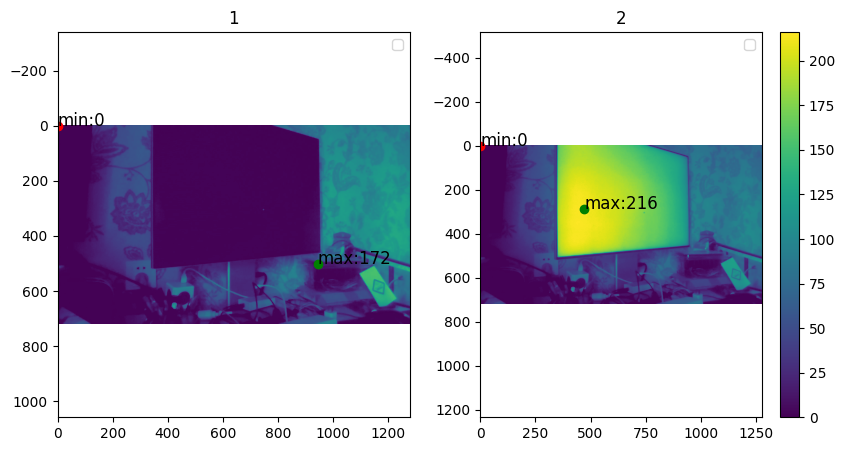

In [31]:
n_cols, n_rows = computeNumberOfPatternImages(pro_size[0], pro_size[1])
#根据投影图像的尺寸log2再*2，计算出需要多少张格雷码图像来完全编码这个空间
n_patterns = n_cols + n_rows#1920*1080下22+22=44  张图片
black_img, white_img = captured_gray_images[n_patterns:n_patterns + 2]
#生成阴影掩码: 使用一对黑白图像 格雷码序列的最后两张图像来生成一个阴影掩码，这个掩码用于标识图像中有效的区域和被阴影遮挡的区域。
def check2map(i1,i2):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('1')
    plt.imshow(i1)
    ni1=i1.copy()
    ni1[np.isnan(ni1)] = 0 #过滤一下nan
    min_val = np.min(ni1)
    max_val = np.max(ni1)
    min_y, min_x = np.unravel_index(ni1.argmin(), ni1.shape)
    max_y, max_x = np.unravel_index(ni1.argmax(), ni1.shape)
    plt.plot(min_x, min_y, 'ro')
    plt.text(min_x, min_y, 'min:' + str(min_val), fontsize=12)
    plt.plot(max_x, max_y, 'go')
    plt.text(max_x, max_y, 'max:' + str(max_val), fontsize=12)
    plt.legend()
    plt.axis('equal')

    plt.subplot(1, 2, 2)
    plt.title('2')
    plt.imshow(i2)
    ni2=i2.copy()
    ni2[np.isnan(ni2)] = 0 #过滤一下nan
    min_val = np.min(ni2)
    max_val = np.max(ni2)
    min_y, min_x = np.unravel_index(ni2.argmin(), ni2.shape)
    max_y, max_x = np.unravel_index(ni2.argmax(), ni2.shape)
    plt.plot(min_x, min_y, 'ro')
    plt.text(min_x, min_y, 'min:' + str(min_val), fontsize=12)
    plt.plot(max_x, max_y, 'go')
    plt.text(max_x, max_y, 'max:' + str(max_val), fontsize=12)
    plt.axis('equal')
    plt.legend()
    plt.colorbar()




    # 显示图形
check2map(black_img,white_img)

#### 用全白-全黑剩余 

In [32]:
shadow_thresh=0 #调的越小越亮
shadow_mask = white_img.astype(np.int32) - black_img.astype(np.int32)
shadow_mask = np.greater(shadow_mask, shadow_thresh)#shadow_thresh
shadow_mask = shadow_mask.astype(np.uint8) * 255
if allvisualization:
    plt.imshow(shadow_mask, cmap='gray')


In [33]:
# import ipywidgets as widgets
# from IPython.display import display
# code_mask = white_img.astype(np.int32) + black_img.astype(np.int32) / 2
# # 获取图像中心点坐标和像素值
# center_x = code_mask.shape[1] // 2
# center_y = code_mask.shape[0] // 2
# center_value = code_mask[center_y, center_x]
# # 创建图像显示
# img = widgets.Image(value=code_mask, format="png")
# # 创建文本显示灰度值
# text = widgets.Text(value="")
# def on_click(change):
#     if change["new"]:
#         x = change["owner"].x
#         y = change["owner"].y
#         gray_value = code_mask[y, x]
#         text.value = f"灰度值:{gray_value}"
# img.observe(on_click, "selected_x")
# img.observe(on_click, "selected_y")
# # 展示组件
# display(img, text)


In [34]:
code_thresh=2#减小之后点会增多
gray_col_stack = np.stack(captured_gray_images[0:n_cols:2]).astype(np.int32) - np.stack(captured_gray_images[1:n_cols:2]).astype(np.int32)
#这两行代码提取捕获的灰度图像序列 captured_gray_images 中偶数列的像素值，并将其堆叠成一个新的数组 gray_col_stack 。然后，再提取奇数列的像素值，并与偶数列的像素值相减，得到列方向的差值，并转为 int32 类型。
gray_row_stack = np.stack(captured_gray_images[n_cols:n_cols+n_rows:2]).astype(np.int32) - np.stack(captured_gray_images[n_cols+1:n_cols+n_rows:2]).astype(np.int32)

gray_col = np.greater(gray_col_stack, 0)
gray_row = np.greater(gray_row_stack, 0)

dec_mask_col = np.greater(np.abs(gray_col_stack), code_thresh)
dec_mask_row = np.greater(np.abs(gray_row_stack), code_thresh)

dec_mask_col = np.logical_and.reduce(dec_mask_col, axis=0)
dec_mask_row = np.logical_and.reduce(dec_mask_row, axis=0)


dec_mask = np.logical_and(dec_mask_col, dec_mask_row)
mask = np.logical_and(dec_mask, shadow_mask)
# 创建一个大图，其中包含所有gray_col[index]的子图
def checkcol(rcol):
    n_subplots = rcol.shape[0]
    fig, axes = plt.subplots(1, n_subplots, figsize=(n_subplots * 5, 5))
    for i in range(n_subplots):
        axes[i].imshow(rcol[i], cmap='gray')
        axes[i].set_title(f'Gray Code Column {i}')
    plt.show()
if allvisualization:
    checkcol(gray_col_stack)
    checkcol(gray_col)#竖条的
    checkcol(gray_row)



In [35]:
if allvisualization:
    check2map(dec_mask_col,dec_mask_row)
print(gray_col.shape)  #列掩码 竖着的
print(gray_row.shape)  #行掩码
print(dec_mask_col.shape)
print(dec_mask_row.shape)

print(mask.shape)#720 1280 宽x高  行x列
if allvisualization:
    check2map(dec_mask_row,mask)


(10, 720, 1280)
(9, 720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


In [36]:

gray_row = np.greater(gray_row_stack, 0)
dec_mask_row = np.greater(np.abs(gray_row_stack), code_thresh)
dec_mask_row = np.logical_and.reduce(dec_mask_row, axis=0)
dec_mask = np.logical_and(dec_mask_col, dec_mask_row)
mask = np.logical_and(dec_mask, shadow_mask)
# 创建一个大图，其中包含所有gray_col[index]的子图

print(gray_col.shape)  #列掩码 竖着的
print(gray_row.shape)  #行掩码
print(mask.shape)#720 1280 宽x高  行x列

(10, 720, 1280)
(9, 720, 1280)
(720, 1280)


### 2.用gray码生成投影机Gray到相机捕获图像点cmr_match_pjt字典

![image.png](doc\graydecode.png)


In [37]:
def gray_decoder(gray):# 将一个格雷码Gray编码的数字解码为其对应的十进制数。
    dec = 0
    tmp = gray[0]
    if tmp:
        dec += 2 ** (len(gray) - 1)
    for i in range(1, len(gray)):
        tmp = tmp ^ gray[i]
        if tmp:
            dec += 2 ** (len(gray) - i - 1)
    return dec
def cmrmatchpjt(mask):
    cmr_match_pjt = {}
    for i in range(mask.shape[1]):   #长1280
        for j in range(mask.shape[0]):   #宽720
            if mask[j, i]:
                xDec = gray_decoder(gray_col[:, j, i])
                yDec = gray_decoder(gray_row[:, j, i])
                if xDec < pro_size[0] and yDec < pro_size[1]:
                    prj_idx = (projector_id, xDec, yDec)
                    # Projector number and matched coordinates
                    if prj_idx not in cmr_match_pjt:
                        cmr_match_pjt[prj_idx] = []
                    cmr_match_pjt[prj_idx].append((i, j))
    #cmr_match_pjt: 一个字典，键是由投影仪编号和解码后的投影仪图像平面坐标组成的元组，如(0, 1726, 427)
    # 值是一个列表，包含了对应于这些投影仪坐标的相机图像平面上的点的坐标
    # 如  546,   216
    # cmrdictdir='./result/data.txt'
    #test_dict =  {str(key): value for key, value in cmr_match_pjt.items()}\
    # # 将字典转换为JSON格式的字符串，并保存到文件
    # with open(cmrdictdir, 'w', encoding='utf-8') as f:
    #     json.dump(test_dict, f, indent=4, ensure_ascii=False)
    return cmr_match_pjt

cam_match_pro=cmrmatchpjt(mask)



## 建立投影机图像平面坐标与投影图像像素坐标的匹配
= relation(anchors, cmr_match_pjt, ph_coordinate, pro_size, cam_size)


### 4.在投影仪的图像平面坐标和cam图像平面坐标之间建立一一对应的关系。
目标map_x, map_y 

输入cmr_match_pjt通过插值方法实现这一点，并返回一个包含映射信息的矩阵。


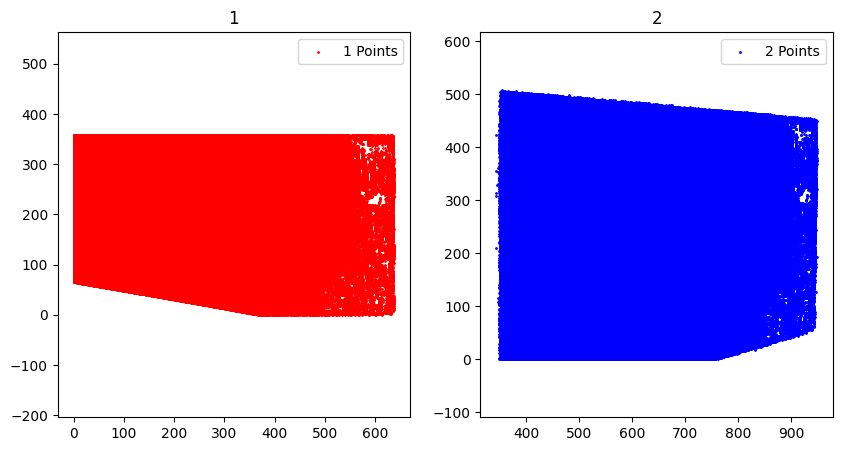

In [38]:
# The matching of each point in the image plane of the projector and the camera is accomplished using interpolation, and unmatched points are recorded as Nan
pro_know = [] # The coordinates of the projection plane
cam_know = [] # The coordinates of the camera plane
for i in cam_match_pro:
    pro_know.append(i[1:])#i[1:]，代码获取了元组中的后两个元素（x和y坐标）
    cam_know.append(cam_match_pro[i][0])
# - 首先，函数遍历 cmr_match_pjt 中的每个条目，将投影仪平面的坐标和相机平面的坐标分别存储在 `pro_know` 和 `cam_know` 列表中。
pro_know = np.array(pro_know)
cam_know = np.array(np.array(cam_know).reshape(-1,2))#reshape(-1, 2)中的-1表示根据数组的大小自动确定该维度
def check2scatter(pro_know,cam_know):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('1')
    plt.scatter(pro_know[:, 0], pro_know[:, 1], s=1,c='red', label='1 Points')
    plt.legend()
    plt.axis('equal')
    plt.subplot(1, 2, 2)
    plt.title('2')
    plt.scatter(cam_know[:, 0], cam_know[:, 1], s=1,c='blue', label='2 Points')
    plt.axis('equal')
    plt.legend()
    plt.show()
check2scatter(pro_know,cam_know)

In [39]:
# Interpolation to achieve a one-to-one correspondence between the projection plane and the camera plane results are stored in cam_pro
# (how the points in pro are filled into cam)
#插值实现投影平面和相机平面的一对一对应结果存储在cam_pro中
grid_x = np.linspace(0, cam_size[0]-1, cam_size[0])  # x coordinate range
grid_y = np.linspace(0, cam_size[1]-1, cam_size[1])  # y coordinate range

grid_x, grid_y = np.meshgrid(grid_x, grid_y)
if allvisualization:
    check2map(grid_x,grid_y)


[[0.000e+00 0.000e+00]
 [1.000e+00 0.000e+00]
 [2.000e+00 0.000e+00]
 ...
 [1.277e+03 7.190e+02]
 [1.278e+03 7.190e+02]
 [1.279e+03 7.190e+02]]
(921600, 2)


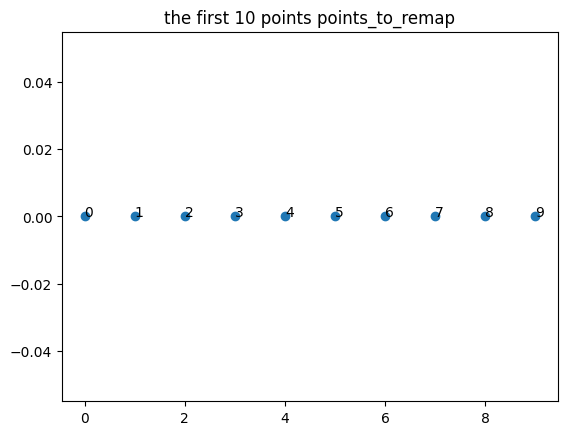

(164036, 2)
(164036, 2)


In [40]:

points_to_remap = np.column_stack((grid_x.flatten(), grid_y.flatten()))
#是否 适配camknow   480p到1080p
#check2scatter(pro_know,points_to_remap)

print(points_to_remap)
print(points_to_remap.shape)
#points_to_remap是一个二维数组,每一行表示图像中一个像素点的(x, y)坐标。

# 取前10个点
points = points_to_remap[:10]
# 绘制点并添加标号
plt.scatter(points[:,0], points[:,1])
for i in range(len(points)):
    plt.annotate(i, (points[i,0], points[i,1]))
plt.title('the first 10 points points_to_remap')
plt.show()

print(cam_know.shape)
print(pro_know.shape)

campro是一个很稀疏的矩阵

In [41]:
#函数将 cam_know 中的点映射到 pro_know 中的点，通过插值方法填充整个相机图像平面，得到 cam_pro。
cam_pro = griddata(cam_know, pro_know, points_to_remap, method='linear')
# The 'method' parameter in the griddata function specifies the interpolation method to use. Some common methods include:
# - 'linear': Linear interpolation
# - 'nearest': Nearest-neighbor interpolation
# - 'cubic': Cubic interpolation
# - 'quintic': Quintic interpolation
# - 'linearND': Linear interpolation in N dimensions
# - 'cubicND': Cubic interpolation in N dimensions
if allvisualization:

    plt.scatter(points_to_remap[:,0], points_to_remap[:,1], c='blue')
    plt.scatter(cam_pro[:,0], cam_pro[:,1], c='red')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mapping from points_to_remap to cam_pro')

    plt.show()
    # 取前10个点
    # 找到非nan的索引
    non_nan_idx = np.where(~np.isnan(cam_pro))[0]
    # 取前10个非nan点
    points = cam_pro[non_nan_idx[:10]]
    # 绘制点并添加标号
    plt.scatter(points[:,0], points[:,1])
    for i in range(len(points)):
        plt.annotate(i, (points[i,0], points[i,1]))
    plt.title('the first 10 noNaN points cam_pro')
    plt.show()

print(cam_pro)
print(cam_pro.shape)

non_nan_count = np.count_nonzero(~np.isnan(cam_pro))
total_count = np.prod(cam_pro.shape)
non_nan_ratio = non_nan_count / total_count

print(f"Non-NaN count: {non_nan_count}")
print(f"Non-NaN ratio: {non_nan_ratio:.2%}")


[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
(921600, 2)
Non-NaN count: 571158
Non-NaN ratio: 30.99%


In [42]:
map_x = np.zeros([cam_size[1], cam_size[0]], dtype=float)
map_y = np.zeros([cam_size[1], cam_size[0]], dtype=float)
print(map_x)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


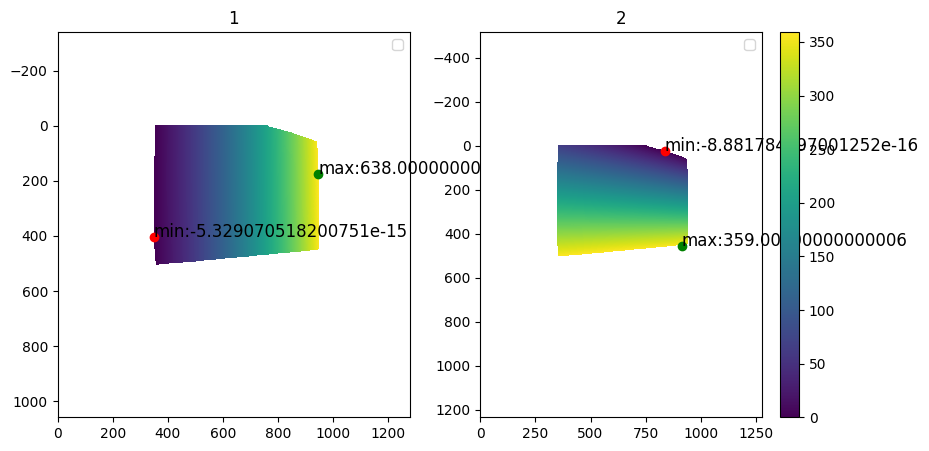

In [43]:
for idx, num in enumerate(cam_pro):
    map_x[idx // cam_size[0]][idx % cam_size[0]] = num[0]
    map_y[idx // cam_size[0]][idx % cam_size[0]] = num[1]
#这段代码片段基于索引将插值点从cam_pro映射到map_x和map_y矩阵。
#它将每个点的x坐标分配给map_x, y坐标分配给map_y
#check2map(map_x,map_y)
map_x, map_y = map_x.reshape(-1, map_x.shape[0], map_x.shape[1]), map_y.reshape(-1, map_x.shape[0], map_x.shape[1])
#将二维数组 map_x 调整形状为三维
matrix = np.concatenate((map_x, map_y), axis=0)
check2map(matrix[0],matrix[1])


## Aruco建立真实世界坐标与相机坐标和像素坐标

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


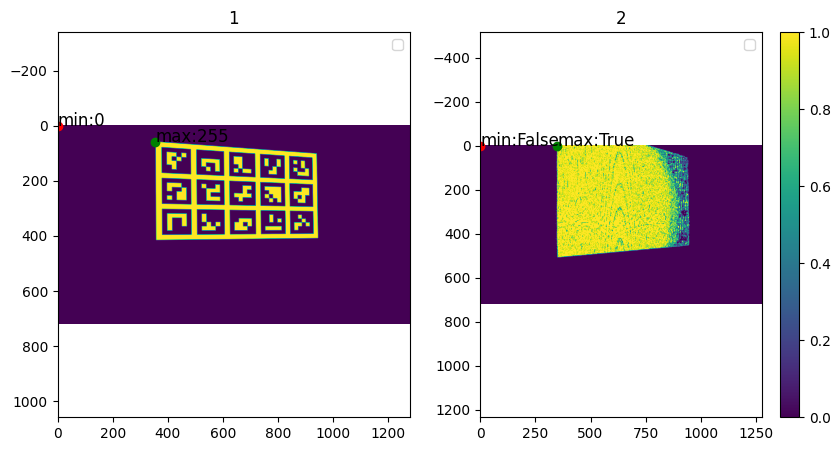

In [44]:
Aruco_img = cv2.imread(aruco_img_path)


check2map(cv2.cvtColor(Aruco_img, cv2.COLOR_BGR2GRAY),mask)

### 生成字典dict1,转置没啥用

In [45]:
#读取一张特定的图像并使用 Aruco_detect 函数检测其中的Aruco标记，得到 anchors。
# Aruco code position detection in the camera image plane
def dict1():
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    myByteList = []
    for idx, code in enumerate(aruco_dict.bytesList):
        #遍历现有Aruco字典（aruco_dict.bytesList）中的每个编码（code）
        code = code[np.newaxis, :, :]
        # 将当前的code通过np.newaxis增加一个维度，以适配cv2.aruco.Dictionary_getBitsFromByteList函数的输入要求。
        bits = cv2.aruco.Dictionary_getBitsFromByteList(code, 4)
        #cv2.aruco.Dictionary_getBitsFromByteList函数将字节列表转换为位矩阵（bits）。
        bits = cv2.flip(bits, 1)
        #使用cv2.flip函数沿着水平方向（参数为1）翻转位矩阵，这可能是为了满足特定的标记识别要求或纠正方向。
        code = cv2.aruco.Dictionary_getByteListFromBits(bits)
        # 将翻转后的位矩阵(bits)重新转换为字节列表(code)，以便后续使用。
        myByteList.append(code[0])
        #将转换后的字节列表添加到myByteList中。
    myByteList = np.stack(myByteList, axis=0)
    return myByteList
dict1 = cv2.aruco.Dictionary(dict1(), 4)


### 3.检测Aruco码
得到anchors 15个点对应的中心位置

corners : 15


C:\Users\robert\AppData\Local\Temp\ipykernel_28432\2622784773.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


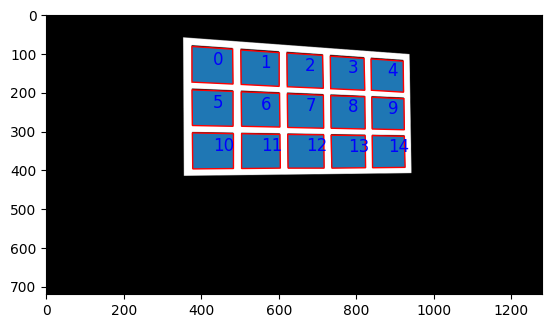

In [46]:
def Aruco_detect1(Aruco_img,dict1):
    anchors = {}
    corners, ids, _ = cv2.aruco.detectMarkers(Aruco_img, dict1, parameters=cv2.aruco.DetectorParameters())
    print('corners :',len(corners))
    if len(corners) == 0:
        print("Please retest")
        raise AssertionError

    if ids is not None:
        corners = np.array(corners).reshape(-1, 4, 2)
        center_points = np.mean(corners, 1)
    for i, idx in enumerate(ids):
        idx = int(idx)
        anchors[idx] = center_points[i]
    checkacruco(corners,anchors)
    return anchors
def checkacruco(corners,anchors):
    fig, ax = plt.subplots()
    for corner in corners:
        points = corner.reshape(-1, 2)
        polygon = plt.Polygon(points, edgecolor='r')
        ax.add_patch(polygon)
    for anchor_id, center_point in anchors.items():
        plt.text(center_point[0], center_point[1], str(anchor_id), color='blue', fontsize=12)
    plt.imshow(Aruco_img, cmap='gray')
    plt.show()
anchors=Aruco_detect1(Aruco_img, dict1)

# 投影机图像与real中校准点的匹配

查找matrix得到的投影图像与real图像中的校准点的匹配程度

In [47]:
def pro_real_match(matrix, anchors):

    # 投影机图像平面与投影图像中校准点的匹配
    cam_know = [] # The position of the Aruco code in the image plane of the camera
    idx_Aruco = [] # Aruco code number
    for key, value in anchors.items():
        cam_know.append(np.array([int(value[1]), int(value[0])]))
        idx_Aruco.append(key)
    cam_know = np.array(cam_know)
    # 投影图像平面和投影图像Matching of projector image plane and projected image
    pro_real = {} # 点的坐标对应于投影仪中的像素点。The coordinates of the points corresponding to the pixel points in the projector.
    for n, m in enumerate(cam_know):
        pro_real[idx_Aruco[n]] = np.array([(matrix[0][m[0]][m[1]]), (matrix[1][m[0]][m[1]])])
    return pro_real
pro_real=pro_real_match(matrix, anchors)

# 投影机图像与待投影图像的校准点的匹配

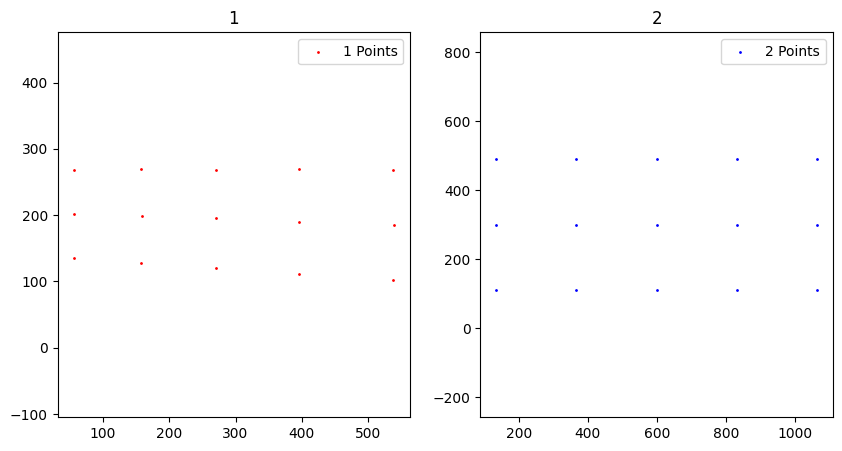

In [48]:
def pro_real_phco_match(pro_real,phcopath):
    # Reading calibrated projected image coordinates
    real_dic = {} # Aruco代码中投影图像的坐标及其对应的id
    #Aruco代码中投影图像的坐标及其对应的id
    real_np = np.loadtxt(phcopath, encoding='utf-8', dtype=float)
    for i in real_np:
        real_dic[i[0]] = [i[1], i[2]]
    pro = [] #投影仪中与投影图像相匹配的点的像素坐标
    real = [] # Pixel coordinates of points where the projected image matches the projector
    #real图像与投影仪相匹配的点的像素坐标
    # 记录投影平面和投影图像的匹配关系
    for key, value in pro_real.items():
        pro.append(value)
        real.append(real_dic[key])
    pro = np.array(pro)
    real = np.array(real)
    check2scatter(pro, real)
    return pro,real
pro,real=pro_real_phco_match(pro_real, phco_path)

### 预测投影机图像平面与投影图像中校准点匹配失败之间的匹配



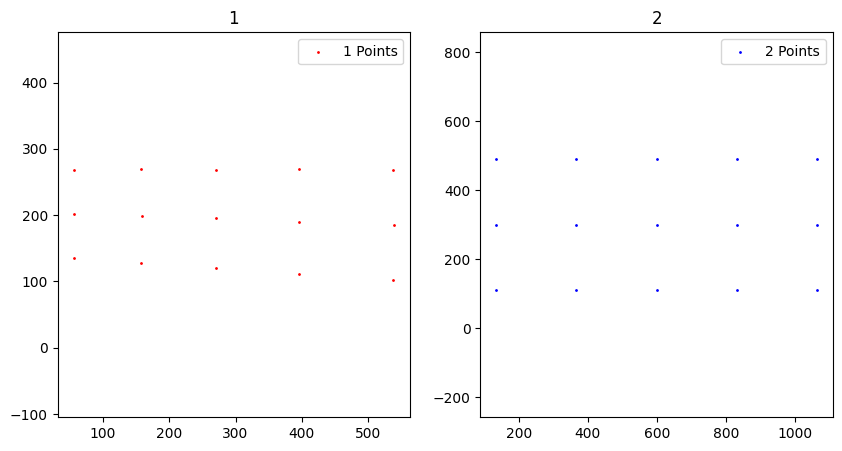

In [49]:

# Predicting the match between the projector image plane and the failure of the calibration points to match in the projected image
def predict_unknow(pro, real):
    pro_unknow = [] # Unknown point in projected coordinates
    real_unknow = [] # pro_unknow corresponds to the points in the projected image
    pro_know = [] # Projected coordinates of known points
    real_know = [] # pro_know corresponds to the point of the projected image
    for idx, num in enumerate(pro):
        if(math.isnan(num[0])):
            pro_unknow.append(num)
            real_unknow.append(real[idx])
        else:
            pro_know.append(num)
            real_know.append(real[idx])
    # Predicting the value of an unknown point by transformation
    if (len(real_unknow)!=0):
        pro_unknow = np.array(pro_unknow)
        real_unknow = np.array(real_unknow)
        pro_know = np.array(pro_know)
        real_know = np.array(real_know)
        print(real_know)
        print('the shape of real_know:',real_know.shape)
        print('the shape of pro_know:',pro_know.shape)
        print('the shape of real_know:',pro_unknow.shape)
        print('the shape of pro_know:',real_unknow.shape)
        transformational_matrix, _ = cv2.findHomography(real_know, pro_know) # transformation matrix
        pro_new = cv2.perspectiveTransform(real_unknow.reshape(-1, 1, 2), transformational_matrix).reshape(-1,2) # Predicted results
        # Record of the matching relationship between the calibration point (real_all) and the projector image plane (pro_all) point in projected images
        pro_all = np.vstack((pro_know,pro_new))
        real_all =  np.vstack((real_know,real_unknow))
    else:
        pro_all = np.array(pro_know)
        real_all =  np.array(real_know)
    check2scatter(pro_all, real_all)
    return pro_all, real_all
pro_all, real_all = predict_unknow(pro, real)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


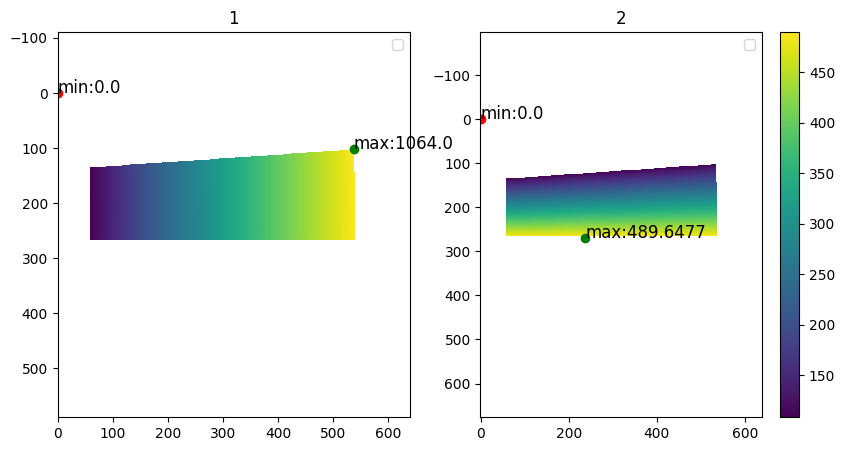

In [50]:

# One-to-one matching of projector image plane coordinates and projected image pixel coordinates
def get_matrix(pro_all, real_all, pro_size):
    # Determine how points in the image plane of the projector are projected into the projected image by interpolation
    grid_x = np.linspace(0, pro_size[0]-1, pro_size[0])
    grid_y = np.linspace(0, pro_size[1]-1, pro_size[1])
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    points_to_remap = np.column_stack((grid_x.flatten(), grid_y.flatten()))
    remapped_points = griddata(pro_all,real_all, points_to_remap, method='cubic')
    mapx = np.zeros([pro_size[1], pro_size[0]], dtype=float)
    mapy = np.zeros([pro_size[1], pro_size[0]], dtype=float)
    for idx, num in enumerate(remapped_points):
        mapx[idx // pro_size[0]][idx % pro_size[0]] = num[0]
        mapy[idx // pro_size[0]][idx % pro_size[0]] = num[1]
    mapx = np.float32(mapx)
    mapy = np.float32(mapy)
    return mapx, mapy
map_x, map_y = get_matrix(pro_all, real_all, pro_size)
check2map(map_x, map_y)

In [51]:


#传入Aruco标记的 anchors、解码得到的匹配信息 cmr_match_pjt、投影图像坐标 ph_coordinate、投影仪尺寸 pro_size 和相机尺寸 cam_size，计算出映射关系，得到 map_x 和 map_y
map_x, map_y = map_x.reshape(1, -1, map_x.shape[0], map_x.shape[1]), map_y.reshape(1, -1, map_x.shape[0], map_x.shape[1])
map_matrix = np.concatenate((map_x, map_y), axis=1)
np.save(match_np_path, map_matrix)

# Render

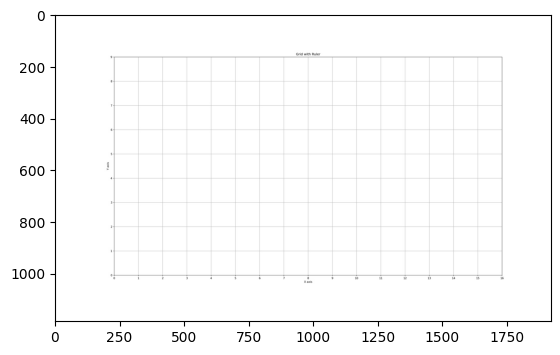

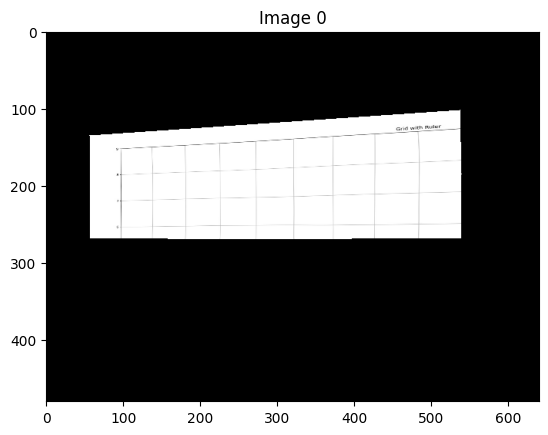

(2, 480, 640)


In [52]:
image = cv2.imread("./pic.png",)
map_matrixs = np.load(match_np_path)
# Corrects the projected image according to the matching result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
for idx,map_matrix in enumerate(map_matrixs):
    part = cv2.remap(image, map_matrix[0], map_matrix[1], interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(f'{"./result/"}/{idx}.png', part)
    plt.imshow(cv2.cvtColor(part, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {idx}')
    plt.show()
print(map_matrix.shape)